In [1]:
devtools::install_github("clairbarnes/rwwa")
suppressMessages(library(rwwa))

Skipping install of 'rwwa' from a github remote, the SHA1 (d0553f57) has not changed since last install.
  Use `force = TRUE` to force installation



# Get 6-month Nino time series

In [2]:
nino <- read.csv("ts/nino34_det.csv", col.names = c("time", "nino"))
nino$nino_6m <- filter(nino$nino, rep(1/6,6), sides = 1)
nino$year <- substr(nino$time,1,4)

nino_6m <- nino[substr(nino$time,6,7) == "11",c("year", "nino_6m")]
write.csv(nino_6m, "ts/nino_6monthly.csv", row.names = F)

# Observed SPEI

In [3]:
# load covariate data
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

nino <- read.csv("ts/nino_6monthly.csv", col.names = c("year", "nino"))

# load time series of interest
ts <- read.csv("ts/cx_spei6_ms.csv")

# combine into single dataframe
df <- merge(merge(gmst, nino), ts)

df$nino_pos <- df$nino
df$nino_pos[df$nino <= 0] <- 0

spei_2023 <- df$spei[df$year == 2023]

cov_2023 <- df[df$year == 2023,c("gmst", "nino", "nino_pos"),drop = F]
cov_cf <- rbind("hist" = cov_2023 - c(1.2,0,0),
                "2000" = cov_2023 - c(0.5,0,0),
                "neut" = c(0,0,0))

In [4]:
pdf("fig/timeseries.pdf", height = 4, width = 7.5); par(cex.axis = 1.4, lwd = 2, cex.lab = 1.3, cex.main = 2); {
    
    par(mar = c(2.2,3.6,1,1))
    plot(df$year-0.5, df$spei, type = "s", lwd = 2, ylim = c(-3,3), xlab = "", ylab = "", bg = "white")

    mtext("SPEI", 2, line = 2.5, cex = par("cex.lab"))

    points(df[df$year == 2023,c("year", "spei")],pch = 22, bg = "magenta", lwd = 2, cex = 1.2)
    abline(h = 0, lty = 2)
    lines(df$year, fitted(loess(spei ~ year, df)), col = "forestgreen", lty = "32", lwd = 3)
    # lines(df$year, df$gmst, lwd = 3, col = "red3")
    # lines(df$year, df$nino, lwd = 2, col = "blue")
    
    legend("bottomleft", c("SPEI", "Loess smoothed"), lty = c("solid","32"), lwd = 2, col = c("black", "forestgreen"))
}; dev.off()

png 
  2

## Model selection

In [5]:
mdl_gmst <- fit_ns("norm", "shift", df, "spei", c("gmst"), lower = T)
mdl_nino <- fit_ns("norm", "shift", df, "spei", c("gmst", "nino"), lower = T)
mdl <- mdl_ninopos <- fit_ns("norm", "shift", df, "spei", c("gmst", "nino_pos"), lower = T)

models <- list("gmst" = mdl_gmst, "nino34" = mdl_nino, "elnino" = mdl_ninopos)

# # bootstrap model results
# res <- boot_ci(mdl, cov_f = cov_2023, cov_cf = cov_cf)
# write.csv(res, "res_obs.csv")

In [6]:
for(mnm in names(models)) {

    mfit = switch(mnm, "gmst" = "", "nino34" = " + Nino3.4", "elnino" = " + positive Nino3.4")
    
    pdf(paste0("fig/model-selection_",mnm,".pdf"), height = 4, width = 7.5); par(cex.axis = 1.4, lwd = 2, cex.lab = 1.3, cex.main = 2); {
        mdl = models[[mnm]]

        par(mar = c(3,3.6,3,1))
        plot_trend(mdl, xlab = "", ylab = "", ylim = c(-3,3), rp = c(20), add_loess = T, legend = "topright", main = paste0("SPEI ~ GMST", mfit))

        mtext("SPEI", 2, line = 2.5, cex = par("cex.lab"))
        abline(h = 0, lty = 2)
    
        text(1979, 2.9, paste0("AIC: ", round(aic(mdl))), adj = 0, cex = 1.3)
        text(1979, 2.3, adj = 0, bquote("R"^2*": "*.(round(rsquared(mdl)[1], 3))), cex = 1.3)
    }; dev.off()
} 

In [7]:
rbind("aic" = round(sapply(models, aic),1), round(sapply(models, rsquared),3))

,gmst,nino34,elnino
aic,129.700,128.400,121.700
r2,0.098,0.161,0.277
r2.adj,0.077,0.121,0.242


## Fitted trend vs covariates

In [50]:
pdf("fig/trend-vs-gmst.pdf", height = 4, width = 9); par(cex.axis = 1.4, lwd = 2, mar = c(4,4,1,1), cex.lab = 1.4, cex.main = 2); {
    plot_covtrend(mdl, "gmst", ylim = c(-3,3), rp = c(20), add_loess = T, legend = "topright", ylab = "SPEI",
                  ci_cov = cbind(cov_cf[,"gmst",drop = F], "nino" = mean(df$nino), "nino_pos" = mean(df$nino_pos)))
    abline(h = 0, lty = 2)
}; dev.off()


png 
  2

In [51]:
pdf("fig/trend-vs-nino.pdf", height = 4, width = 9); par(cex.axis = 1.4, lwd = 2, mar = c(4,4,1,1), cex.lab = 1.3, cex.main = 2); {
    plot_covtrend(mdl_ninopos, "nino", ylim = c(-3,3), add_loess = T, rp = c(20), legend = "topright", ylab = "SPEI",
                    trend_cov = data.frame(sapply(mdl_ninopos$covnm,
                                            function(cnm) if(cnm == "nino_pos") {mdl_ninopos$data[,cnm]} else {mean(mdl_ninopos$data[,cnm])}, simplify = F)),
                    ci_cov = data.frame("gmst" = mean(df$gmst), "nino" = c(0,df$nino[df$year == 2023],1.5), "nino_pos" = c(0,df$nino[df$year == 2023],1.5)))
                                            
    abline(h = 0, lty = 2)
}; dev.off()

png 
  2

In [20]:
sapply(models, function(mdl) c("now" = return_period(mdl, spei_2023, fixed_cov = cov_2023), 
                               sapply(rownames(cov_cf), function(rnm) return_period(mdl, spei_2023, fixed_cov = cov_cf[rnm,,drop = F]))))

,GMST only,Nino3.4,El Nino
now,40.87801,20.11517,16.66316
hist,4824.73488,3800.63062,3753.13974
2000,227.33912,123.91083,106.55639
neut,40.87801,35.84598,129.41116


## Return level plots

In [52]:
prep_window(c(1,2))

pdf("fig/return-levels_gmst.pdf", height = 4, width = 9); par(cex.main = 2, cex.axis = 1.4, lwd = 2, mar = c(4,4,1,1), cex.lab = 1.4); {
    plot_returnlevels(mdl_ninopos, cov_f = cov_2023, cov_cf = cov_cf["hist",,drop = F], nsamp = 1000, model_desc = F, ylab = "SPEI", ylim = c(-5,2.5),
                     main = "")
}; dev.off()

pdf("fig/return-levels_nino.pdf", height = 4, width = 9); par(cex.main = 2, cex.axis = 1.4, lwd = 2, mar = c(4,4,1,1), cex.lab = 1.4); {
    plot_returnlevels(mdl_ninopos, cov_f = cov_2023, cov_cf = cov_cf["neut",,drop = F], nsamp = 1000, model_desc = F, ylab = "SPEI", ylim = c(-5,2.5),
                     main = "")
}; dev.off()

png 
  2

png 
  2

# Refit climate models

In [ ]:
# load Nino covariate & standardise wrt obs period
nino_obs <- read.csv("ts/nino_6monthly.csv", col.names = c("year", "nino"))

nino_cal <- nino_obs$nino[(nino_obs$year >= 1979) & (nino_obs$year <= 2024)]
nino_obs$nino_std <- (nino_obs$nino - mean(nino_cal)) / sd(nino_cal)

nino_2023 <- nino_obs$nino_std[nino_obs$year == 2023]

In [ ]:
rp <- 50

for(fnm in list.files("ts", pattern = "spei_SAM", full.names = T)) {
    
    res_fnm <- gsub("ts/", "res/res_", gsub(".dat", ".csv", fnm))
    
    model_name = paste0(strsplit(fnm, "_")[[1]][c(3,5)], collapse = "_")
    gcm <- strsplit(fnm, "_")[[1]][3]
    
    gmst_fnm <- list.files("ts", paste0("smoothed-gsat_", gcm), full.names = T)
    nino_fnm <- list.files("ts", paste0("nino34det_.+", gcm), full.names = T)
    
    # load data
    var <- load_ts(fnm, col.names = c("year", "spei"))
    gmst <- load_ts(gmst_fnm, col.names = c("year", "gmst"))
    nino <- load_ts(nino_fnm, col.names = c("year", "nino"))
    
    # standardise Nino values to use as covariate
    nino_cal <- nino$nino[(nino$year >= 1979) & (nino$year <= 2024)]
    nino$nino_std <- (nino$nino - mean(nino_cal)) / sd(nino_cal)
    nino$nino_std[nino$nino_std < 0] <- 0
    
    # merge into single dataframe
    df <- merge(merge(gmst, nino), var)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # SPECIFY MODEL TO BE ANALYSED

    # value of covariate in present/factual climate
    gmst_2023 = df$gmst[df$year == 2023]
    
    cov_2023 <- data.frame(gmst = gmst_2023, nino_std = nino_2023)
    cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0),
                    "neut" = c(gmst = gmst_2023, 0))
    cov_fut <- cov_2023 + c(0.8, 0)

    # fit the model - this is used as a template for the attribution
    mdl <- fit_ns("norm", "shift", df, "spei", c("gmst", "nino_std"), lower = T)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    res_df <- cmodel_results(mdl, rp = rp, cov_f = cov_2023, cov_hist = cov_cf, cov_fut = cov_fut, nsamp = 1000, y_start = 1979, y_now = 2023, y_fut = 2050)
    write.csv(res_df, res_fnm)

}

In [ ]:
# compile results
res <- t(sapply(list.files("res", pattern = "SAM", full.names = T), read.csv, row.names = "X"))
rownames(res) <- sapply(rownames(res), function(rnm) paste0(strsplit(rnm, "_")[[1]][c(4,6)], collapse = "_"))
write.csv(res, "res_cmip6_cordex.csv")

# Synthesis

In [15]:
obs_res <- read.csv("res_obs.csv", row.names = "X")
obs_res <- as.data.frame(t(unlist(lapply(rownames(obs_res), function(cnm) setNames(obs_res[cnm,], paste(gsub("_", "-", cnm), c("est", "lower", "upper"), sep = "_"))))))
rownames(obs_res) <- "MSWX"    

In [16]:
model_res <- read.csv("res_cordex.csv", row.names = "X")

In [17]:
synth_pr_attr <- synthesis(obs_res[,grepl("PR-hist", colnames(obs_res))], model_res[,grepl("attr_PR.hist", colnames(model_res))], synth_type = "PR")
synth_dI_attr <- synthesis(obs_res[,grepl("dI-abs-hist", colnames(obs_res))], model_res[,grepl("attr_dI.abs.hist", colnames(model_res))])

synth_pr_neut <- synthesis(obs_res[,grepl("PR-neut", colnames(obs_res))], model_res[,grepl("attr_PR.neut", colnames(model_res))], synth_type = "PR")
synth_dI_neut <- synthesis(obs_res[,grepl("dI-abs-neut", colnames(obs_res))], model_res[,grepl("attr_dI.abs.neut", colnames(model_res))])

In [18]:
prep_window(c(1,2), mar = c(2,0.5,3,0.5), oma = c(2,11,0,0))

pdf("fig/synthesis_int-change.pdf", height = 5, width = 10); par(mfrow = c(1,2), mar = c(2,0.5,3,0.5), oma = c(2,11,0,0)); {
    plot_synthesis(synth_dI_attr, xlim = c(-3.5,0.5), main = "Associated with\n1.2C increase in GMST")
    plot_synthesis(synth_dI_neut, xlim = c(-3.5,0.5), main = "Associated with\n2023 ENSO conditions", hide_labels = T)

    mtext("Change in SPEI", 1, outer = T, line = 0.5)
}; dev.off()

png 
  2

In [19]:
prep_window(c(1,2), mar = c(2,0.5,3,0.5), oma = c(2,11,0,0))

pdf("fig/synthesis_PR.pdf", height = 5, width = 9); par(mfrow = c(1,2), mar = c(2,0.5,3,0.25), oma = c(0,12.5,0,0), cex.main = 1.2, cex.axis = 1.2); {
    
    plot_synthesis(synth_pr_attr, xlim = c(1e-1, 1e+6), main = "Associated with\n1.2C increase in GMST")
    plot_synthesis(synth_pr_neut, xlim = c(1e-1, 1e+6), main = "Associated with\n2023 ENSO conditions", hide_labels = T)

    # mtext("Probability ratio", 1, outer = T, line = 0.5)
}; dev.off()

png 
  2

In [20]:
synth_pr_neut

group,model,est,lower,upper,l_wb,u_wb
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
obs,MSWX,7.766306,2.3740926,33.18614,2.3740926,33.18614
obs_synth,Observations,7.766306,2.3740926,33.18614,NA,NA
models,MPI-ESM-LR_REMO2015,2.797073,0.4524922,71.80275,0.3623806,81.74284
models,NorESM1-M_REMO2015,18.326647,2.9775071,265.96055,2.3834379,310.83042
models,CanESM2_RCA4,7.915341,2.7568198,57.28426,1.9443886,70.39608
models,HadGEM2-ES_RCA4,7.129323,1.8406212,47.40954,1.3819406,58.74587
models,MIROC5_RCA4,57.715676,14.6476514,426.09184,11.0301309,522.64668
models,MPI-ESM-LR_RCA4,7.005119,1.5712697,108.12698,1.2068868,125.94936
model_synth,Models,11.274931,3.7736770,42.14895,NA,NA


# Modified plots for intro slide

In [14]:
pdf(paste0("fig/slide_model-selection_",mnm,".pdf"), height = 4, width = 9); par(mar = c(4,4,1,1), cex.axis = 1.4, lwd = 2, cex.lab = 1.4, cex.main = 2); {

        plot_trend(mdl_ninopos, xlab = "", ylab = "", ylim = c(-3,3), rp = c(20), add_loess = T, legend = "topright", main = "")

        mtext("SPEI", 2, line = 2.5, cex = par("cex.lab"))
        abline(h = 0, lty = 2)
    
        text(1979, 2.9, paste0("AIC: ", round(aic(mdl_ninopos))), adj = 0, cex = 1.3)
        text(1979, 2.3, adj = 0, bquote("R"^2*": "*.(round(rsquared(mdl_ninopos)[1], 3))), cex = 1.3)
    }; dev.off()

png 
  2

In [24]:
pdf("fig/slide_return-levels_nino.pdf", height = 4, width = 9); par(cex.main = 2, cex.axis = 1.4, lwd = 2, mar = c(4,4,1,1), cex.lab = 1.4); {
    plot_returnlevels(mdl_ninopos, cov_f = cov_2023, cov_cf = cov_cf["neut",,drop = F], nsamp = 1000, model_desc = F, ylab = "SPEI", ylim = c(-5,2.5),
                     main = "")
}; dev.off()

png 
  2

In [25]:
pdf("fig/slide_synthesis_PR.pdf", height = 5, width = 5); par(mar = c(2,0.5,1,1), oma = c(0,13,0,0), cex.main = 1.2, cex.axis = 1.2); {
    plot_synthesis(synth_pr_attr, xlim = c(1e-1, 1e+6), main = "")
}; dev.off()

png 
  2

---
# Joint distribution of PET, PR & SPEI

In [53]:
library(copula)

# compute joint exceedances over regular grid for easy plotting
copula_mesh <- function(mdl_x, mdl_y, copula, cov1, xrange, yrange, n = 32) {
    
    # compute joint exceedances over regular grid for easy plotting
    
    if(missing(xrange)) xrange <- range(pretty(mdl_x$x))
    if(missing(yrange)) yrange <- range(pretty(mdl_y$x))
    
    # define the regular mesh for plotting
    x_mesh <- seq(xrange[1], xrange[2],length.out = n)
    y_mesh <- seq(yrange[1], yrange[2], length.out = n)
    
    # convert the regular mesh to U space
    x_umesh <- map_to_u(mdl_x, x_mesh, fixed_cov = cov1)
    y_umesh <- map_to_u(mdl_y, y_mesh, fixed_cov = cov1)
    
    if(substr(mdl_x$varnm,1,5) == "log10") { x_mesh <- 10^x_mesh }
    if(substr(mdl_y$varnm,1,5) == "log10") { y_mesh <- 10^y_mesh }
    
    return(list("x" = x_mesh, "y" = y_mesh, "z" = sapply(y_umesh, function(y) sapply(x_umesh, function(x) pCopula(cbind(x,y), copula)))))
}

In [54]:
# load covariate data
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

nino <- read.csv("ts/nino_6monthly.csv", col.names = c("year", "nino"))
nino$nino_pos <- nino$nino
nino$nino_pos[nino$nino <= 0] <- 0

# load time series of interest
pet <- read.csv("ts/cx_pet6_ms.csv")
pr <- read.csv("ts/cx_pr6_ms.csv", col.names = c("year", "pr"))

# compile into single dataframe
df <- merge(merge(merge(gmst, nino), pet), pr)

# covariates to define scenarios
cov_2023 <- df[df$year == 2023,c("gmst", "nino", "nino_pos"),drop = F]

cov_cf <- rbind("histnino" = cov_2023 - c(1.2,0,0),
                "2023neut" = c(0,0,0),
                "histneut" = c(-1.2,0,0))

## Check marginals: pet, pr ~ gmst + nino

In [55]:
# fit marginal distributions

models_pet <- sapply(list("GMST only" = "gmst", "GMST + ENSO" = c("gmst", "nino"), "GMST + Nino" = c("gmst", "nino_pos")), function(covariates) {
    fit_ns("norm", type = "shift", data = df, varnm = "pet", covnm = covariates, lower = F)
}, simplify = F)

models_pr <- sapply(list("GMST only" = "gmst", "GMST + ENSO" = c("gmst", "nino"), "GMST + Nino" = c("gmst", "nino_pos")), function(covariates) {
    fit_ns("norm", type = "fixeddisp", data = df, varnm = "pr", covnm = covariates, lower = T)
}, simplify = F)

In [56]:
print("PET:")
rbind("aic" = sapply(models_pet, aic), sapply(models_pet, rsquared))

[1] "PET:"


,GMST only,GMST + ENSO,GMST + Nino
aic,373.1025583,374.8751532,371.8046204
r2,0.6778241,0.6794481,0.7005911
r2.adj,0.6703316,0.6641837,0.6863335


In [57]:
print("Precip:")
rbind("aic" = sapply(models_pr, aic), sapply(models_pr, rsquared))

[1] "Precip:"


,GMST only,GMST + ENSO,GMST + Nino
aic,501.596007591,497.85810025,489.2972876
r2,0.001912996,0.13216271,0.2777579
r2.adj,-0.021298330,0.09083713,0.2433654


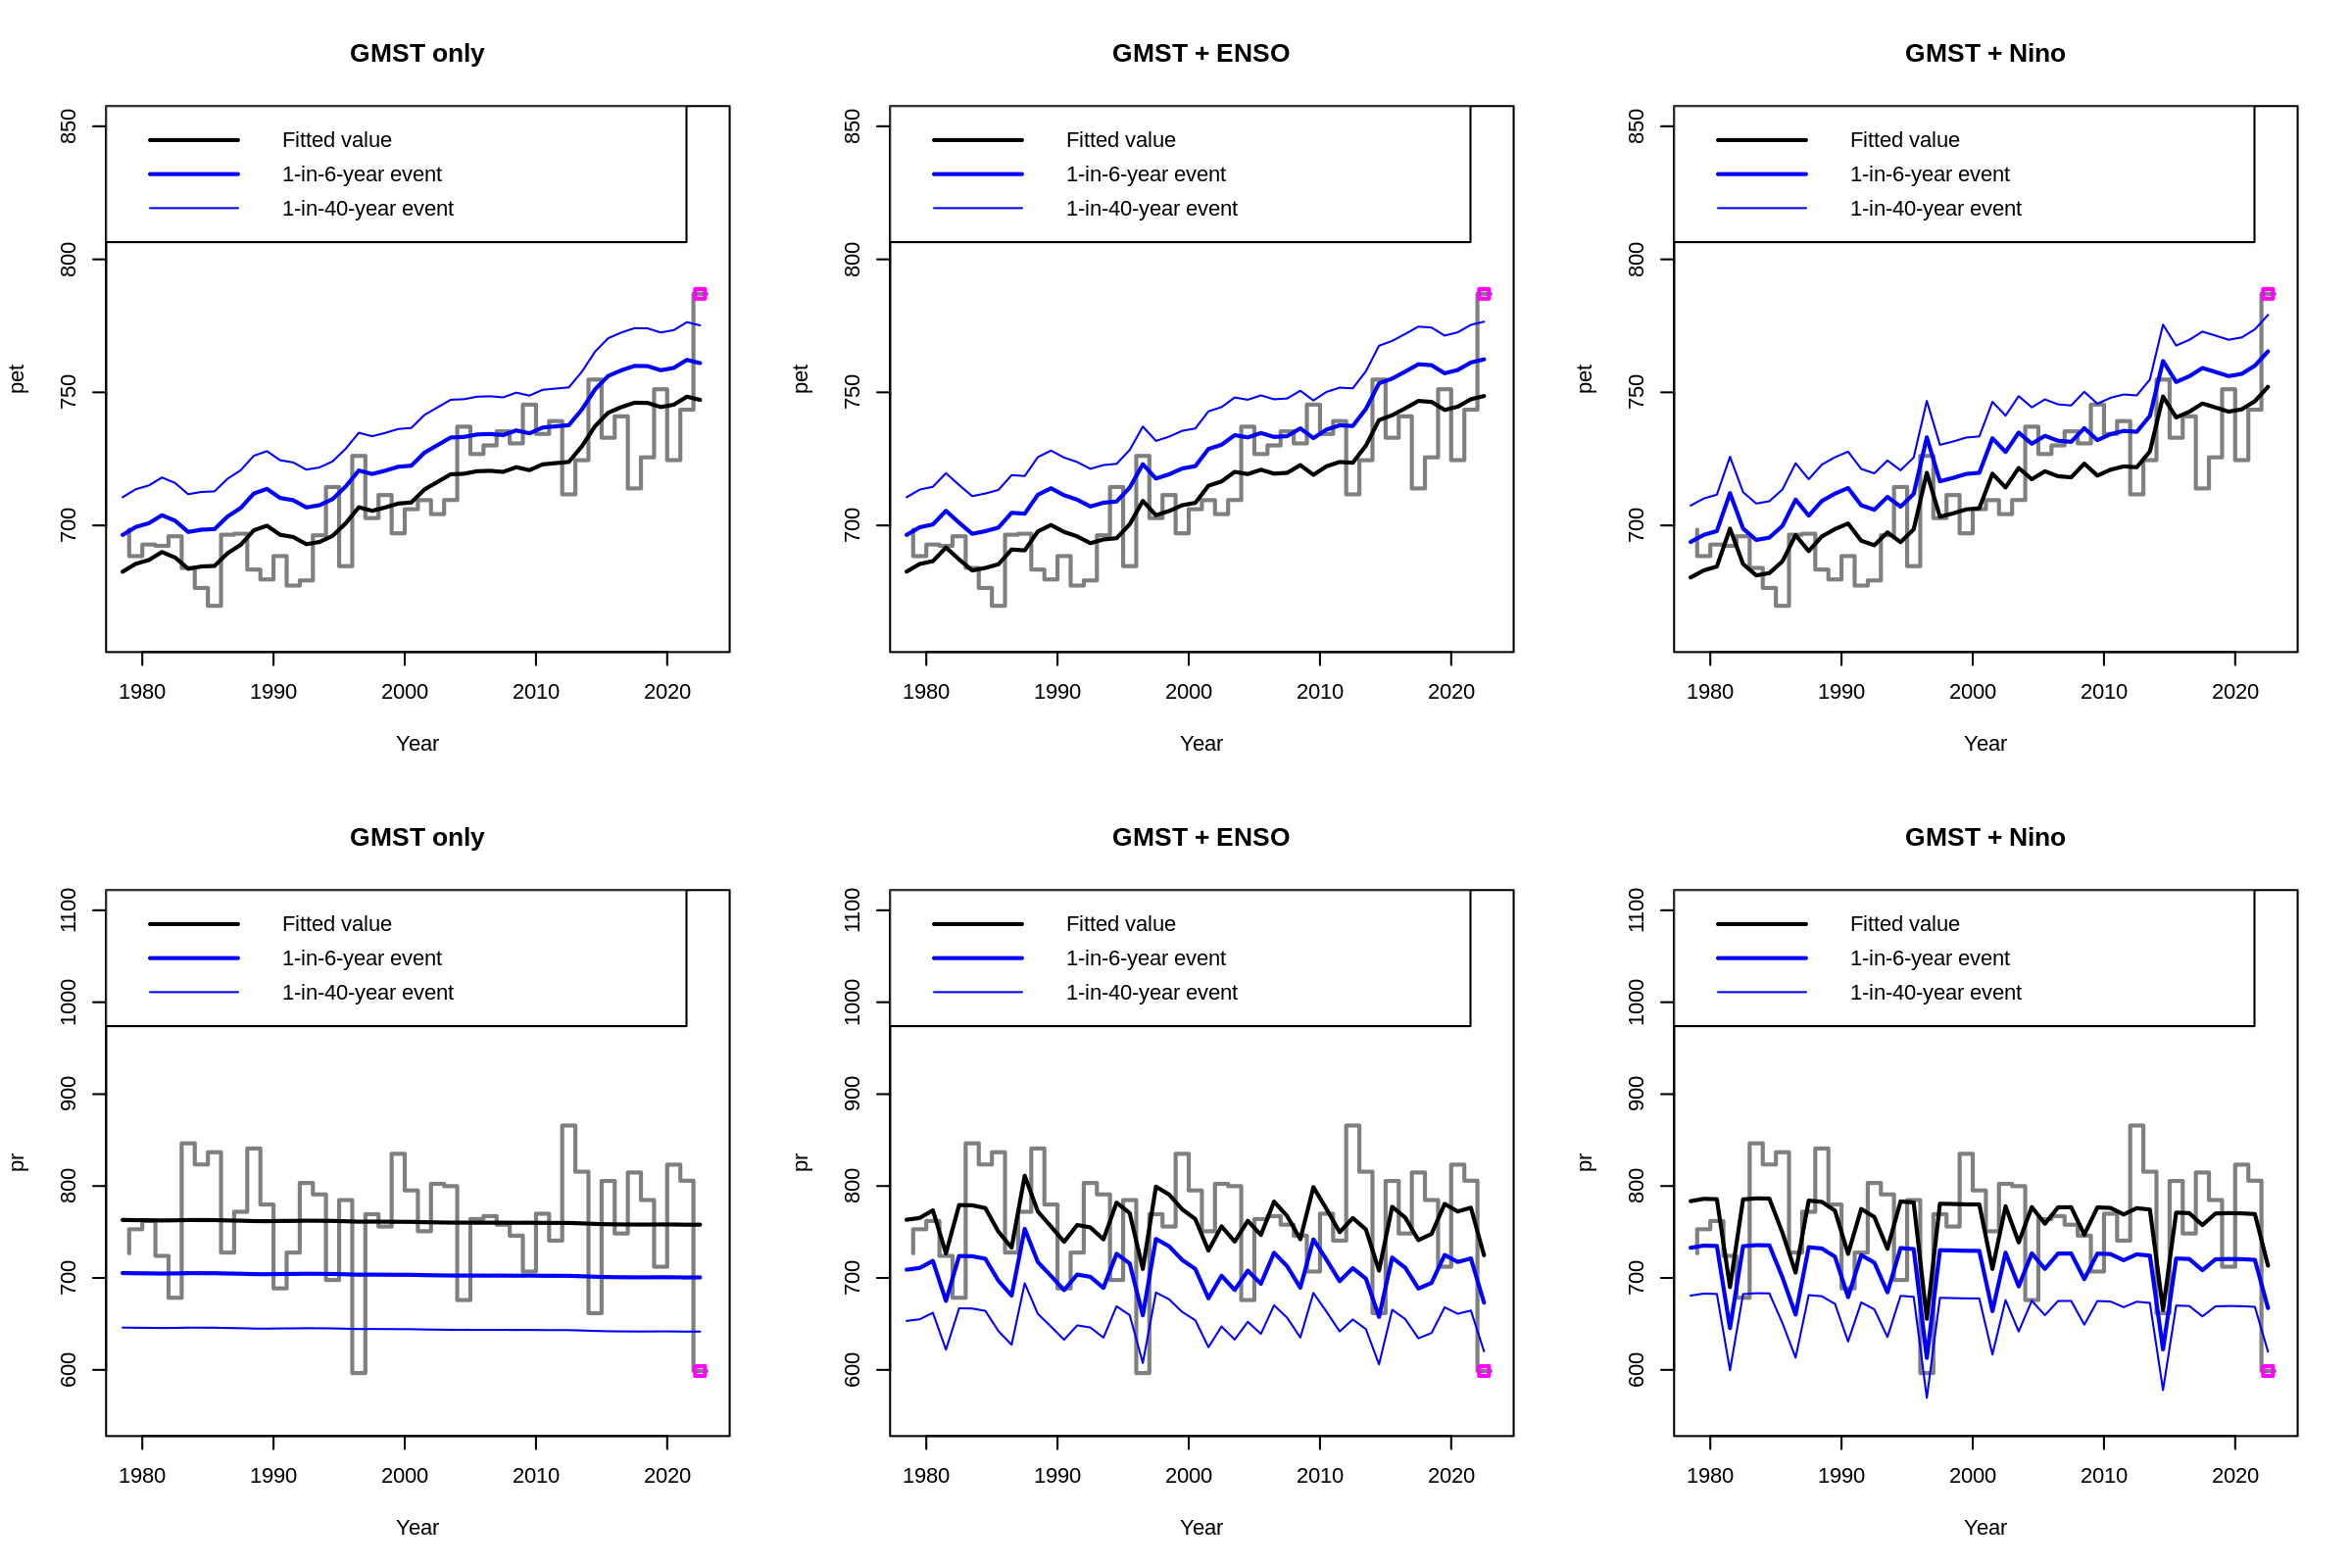

In [58]:
prep_window(c(2,3))

for(mnm in names(models_pet)) plot_trend(models_pet[[mnm]], main = mnm, ylim = c(660,850))
for(mnm in names(models_pr)) plot_trend(models_pr[[mnm]], main = mnm, ylim = c(550,1100))


### Check copula fit

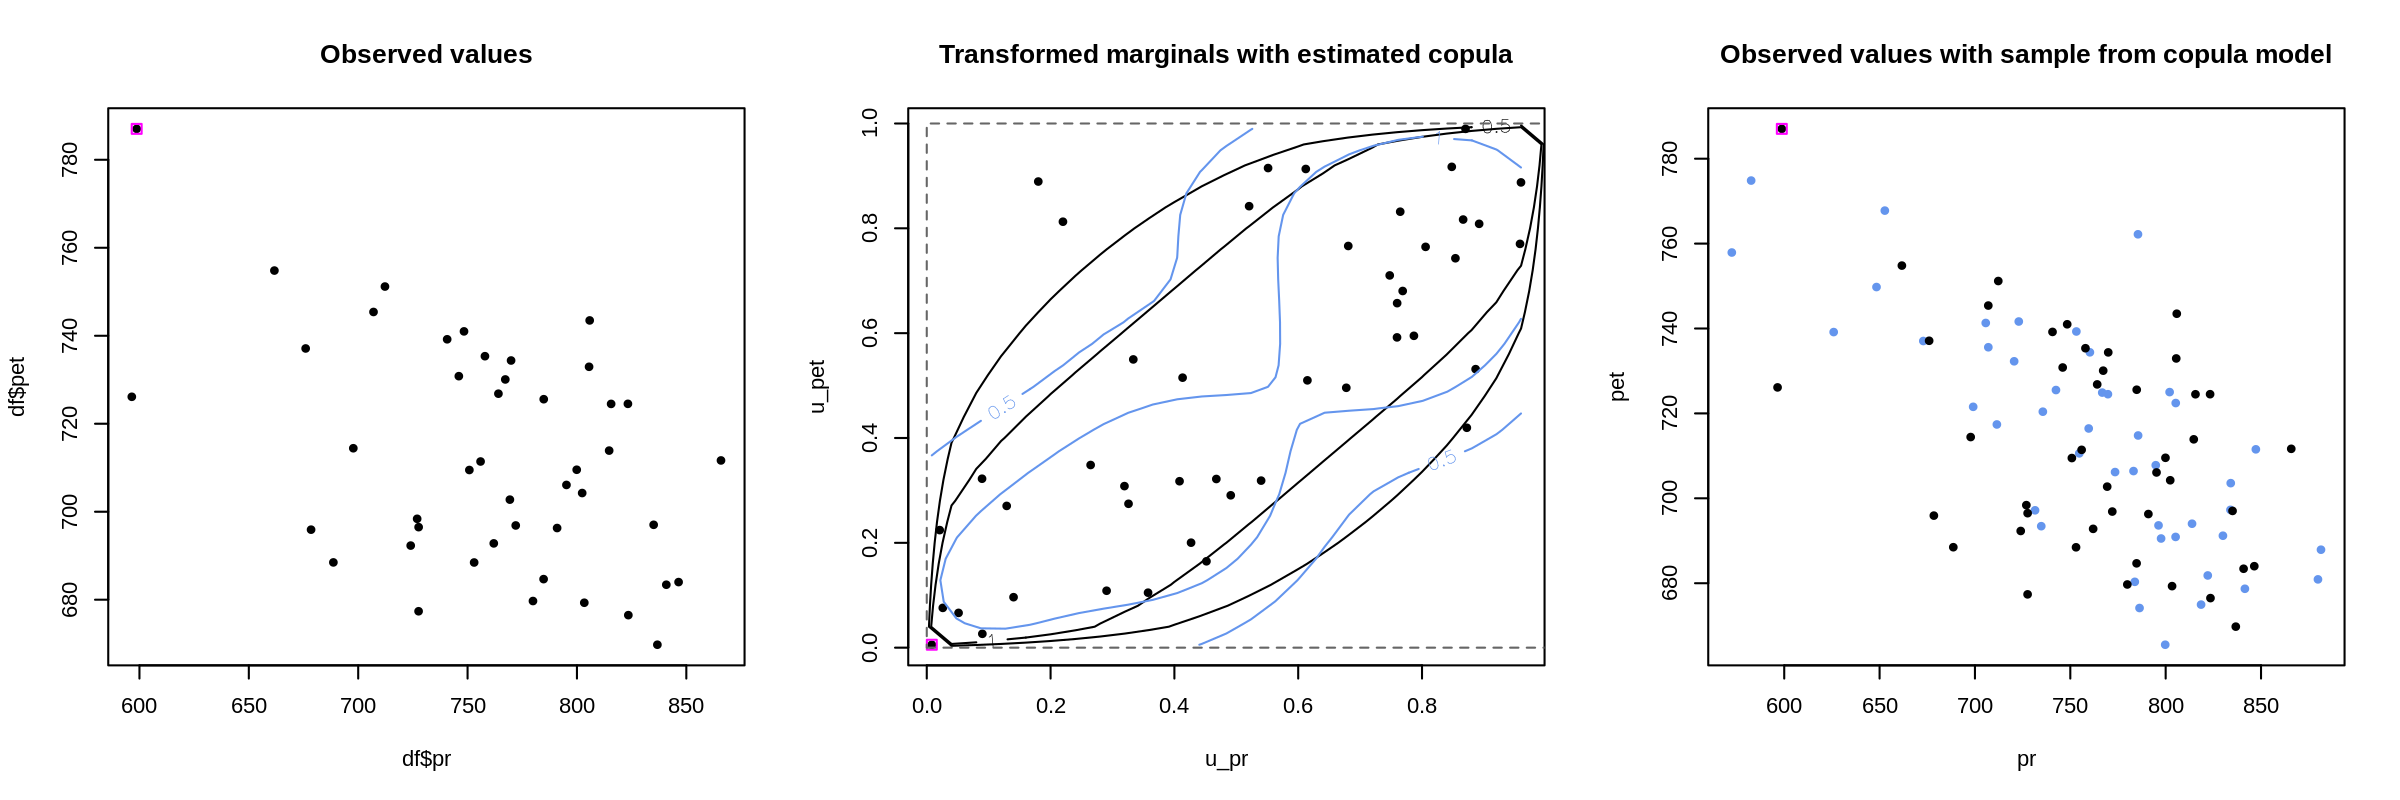

In [59]:
# fit marginal distributions
mdl_pet <- fit_ns("norm", type = "shift", data = df, varnm = "pet", covnm = c("gmst", "nino_pos"), lower = F)
mdl_pr <- fit_ns("norm", type = "fixeddisp", data = df, varnm = "pr", covnm = c("gmst", "nino_pos"), lower = T)  

# transform marginals to U
u_pr <- map_to_u(mdl_pr)
u_pet <- map_to_u(mdl_pet)

fitted_copula <- fitCopula(tCopula(), data = cbind(u_pr, u_pet), hideWarnings = T)  # warning message about using df.fixed is irrelevant: can't actually change this setting

prep_window(c(1,3))

plot(df$pr, df$pet, main = "Observed values")
points(df[df$year == 2023,c("pr","pet")], col = "magenta", pch = 0)

# check fit of copula against 2d KDE
plot(u_pr, u_pet, main = "Transformed marginals with estimated copula")
points(u_pr[df$year == 2023], u_pet[df$year == 2023], col = "magenta", pch = 0)

cop <- tCopula(coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"], 0))
contour(cop, dCopula, add = T, levels = c(0.5,1))
contour(MASS::kde2d(u_pr, u_pet), col = "cornflowerblue", add = T, levels = c(0.5,1))

# generate a sample from the fitted copula to check relationship with actual values
# MVDC needs copula fitted without accounting for lower/upper tails, since it also uses the actual marginals - adjust correlation accordingly
fitted_mvdc <- mvdc(copula = tCopula(-coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"], 0)), 
                    margins=c("norm", "norm"), paramMargins=list(list(mean=mean(df$pr), sd=sd(df$pr)), list(mean=mean(df$pet), sd=sd(df$pet))))

set.seed(42)
mvsamp <- rMvdc(nrow(df), fitted_mvdc)

plot(mvsamp, col = "cornflowerblue", xlim = range(mvsamp[,1], df$pr), ylim = range(mvsamp[,2], df$pet), xlab = "pr", ylab = "pet",
     main = "Observed values with sample from copula model")
points(df$pr, df$pet, pch = 20, col = "black")
points(df[df$year == 2023,c("pr","pet")], col = "magenta", pch = 0)

### **Fit chosen model & get contour values**

In [60]:
cfit <- tCopula(coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"], 0))

In [61]:
# get expected return levels in factual & counterfactual climates
rp_pr <- return_period(mdl_pr)[nrow(df)]
rl_pr <- as.list(c("2023" = eff_return_level(mdl_pr, rp_pr, fixed_cov = cov_2023), 
                               sapply(rownames(cov_cf), function(rnm) eff_return_level(mdl_pr, rp_pr, fixed_cov = cov_cf[rnm,,drop = F]))))

rp_pet <- return_period(mdl_pet)[nrow(df)]
rl_pet <- as.list(c("2023" = eff_return_level(mdl_pet, rp_pet, fixed_cov = cov_2023), 
                               sapply(rownames(cov_cf), function(rnm) eff_return_level(mdl_pet, rp_pet, fixed_cov = cov_cf[rnm,,drop = F]))))

In [62]:
# joint return periods
joint_rp <- as.list(c("2023" = 1/pCopula(c(map_to_u(mdl_pr, mdl_pr$ev, cov_2023), map_to_u(mdl_pet, mdl_pet$ev, cov_2023)), cfit),
  sapply(rownames(cov_cf), function(rnm) 1/pCopula(c(map_to_u(mdl_pr, mdl_pr$ev, cov_cf[rnm,,drop = F]), map_to_u(mdl_pet, mdl_pet$ev, cov_cf[rnm,,drop = F])), cfit))))
joint_rp

$`2023`
[1] 462.4431

$histnino
[1] -4.793054e+16

$`2023neut`
[1] 5475.559

$histneut
[1] 2.809197e+17

In [63]:
# double- check using PI marginals & ERLs - should give the same joint return period as today's event in today's climate
1/pCopula(c(map_to_u(mdl_pr, rl_pr$histnino, cov_cf["histnino",,drop = F]), map_to_u(mdl_pet, rl_pet$histnino, cov_cf["histnino",,drop = F])), cfit)

[1] 462.4431

In [64]:
cmesh_2023 <- copula_mesh(mdl_pr, mdl_pet, cfit, cov_2023, xrange = c(550,900), yrange = c(550,800), n = 64)
cmesh_hist <- copula_mesh(mdl_pr, mdl_pet, cfit, cov_cf["histnino",,drop = F], xrange = c(550,900), yrange = c(550,700))

## Compute gridded SPEI for filled contours

In [65]:
library("SPEI")

# Package SPEI (1.8.1) loaded [try SPEINews()].



In [66]:
# create time series of effective precip
eff_pr <- ts((df$pr - df$pet)[(df$year >= 1990) & (df$year <= 2020)], start = 1990, frequency = 1)
fitted_spei <- spei(eff_pr, scale = 1, verbose = F)

# get intercept of SPEI - can use this to draw polygons for the successive drought categories
spei_0 <- sapply(0:850, function(pe) spei(ts(550 - pe), scale = 1, params = coef(fitted_spei), verbose = F)$fitted)
spei_int <- function(x) which.min(abs(spei_0 - x)) - 550

### **Contour plot**

In [96]:
# check that plot region covers all contours & features of interest
prep_window(c(1,1), lwd = 2)

pt.cex = 2

pr_x = seq(550,900,5)
pet_y = seq(550,800,5)

drought_cols = c("yellow1", "gold", "chocolate1", "red2", "darkred")
nc = length(drought_cols)

pdf("fig/decomposition.pdf", width = 8, height = 7, bg = "white"); par(lwd = 2, mar = c(3.6,3.6,1,1), cex.main = 2, cex.axis = 1.4, cex.lab = 1.3); {
    
    layout(matrix(c(1,2), 1, 2, byrow = TRUE), widths=c(9,1.5))
    
    matplot(0, type = "n", xlim = range(pr_x), ylim = range(pet_y), xlab = "", ylab = "", main = "", xaxs = "i", yaxs = "i")

    # add drought categories
    polygon(x = c(pr_x, rev(pr_x)), y = c(pr_x + spei_int(-0.5), rev(pr_x + spei_int(-0.8))), density = NULL, border = NA, col = drought_cols[1])
    polygon(x = c(pr_x, rev(pr_x)), y = c(pr_x + spei_int(-0.8), rev(pr_x + spei_int(-1.3))), density = NULL, border = NA, col = drought_cols[2])
    polygon(x = c(pr_x, rev(pr_x)), y = c(pr_x + spei_int(-1.3), rev(pr_x + spei_int(-1.6))), density = NULL, border = NA, col = drought_cols[3])
    polygon(x = c(pr_x, rev(pr_x)), y = c(pr_x + spei_int(-1.6), rev(pr_x + spei_int(-2))), density = NULL, border = NA, col = drought_cols[4])
    polygon(x = c(pr_x, rev(pr_x)), y = c(pr_x + spei_int(-2), rev(pr_x + spei_int(-20))), density = NULL, border = NA, col = drought_cols[5])
    box(lwd = 1)
    
    contour(cmesh_2023, levels = 1/c(5,10,20,50), labels = c(5,10,20,50), col = "black", labcex = par("cex.lab"), add = T)

    mtext("Accumulated precipitation (mm)", 1, line = 2.5, cex = par("cex.lab"))
    mtext("Accumulated PET (mm)", 2, line = 2.5, cex = par("cex.lab"))
    # mtext("Joint return levels of PET/PR\nwith SPEI drought class", 3, line = 1, font = 2, cex = par("cex.main"))

    contour(cmesh_hist, levels = 1/c(5,10,20,50), labels = c(5,10,20,50), col = "blue3", lty = 2, labcex = par("cex.lab"), add = T)

    # points(mdl_pr$x, mdl_pet$x, pch = 20)
    
    points(mdl_pr$ev, mdl_pet$ev, pch = 21, bg = "magenta", cex = pt.cex)
    points(rl_pr$"histnino", rl_pet$"histnino", pch = 22, bg = "cyan4", cex = pt.cex)
    points(rl_pr$"2023neut", rl_pet$"2023neut", pch = 23, bg = "cyan", cex = pt.cex)
    
    legend("bottomright", legend = c("2023 climate", "1.2C cooler climate", "2023 climate without El Nino"), pch = c(21,22,23),
           pt.bg = c("magenta", "cyan4", "cyan"), pt.cex = pt.cex, cex = par("cex.lab"))
    
    par(mar=c(3.5,0,2.5,4.5))
    plot(x=rep(1,nc+1), y=1:(nc+1), col=c("white", drought_cols), xaxt = "n", yaxt = "n", xlab = "", ylab = "", ylim = c(0.75,nc+1.25))
    for(i in 1:nc) rect(0,i+.5,2,i+1.5, col = drought_cols[i], border = NA)
    axis(4, at = 1:(nc+1), labels = c("-", paste0("D", (1:nc)-1)), las = 1)
    mtext("Drought classification", 4, line = 3, cex = par("cex.lab"))
    box()
    
}; dev.off()

png 
  2